#Homework 3: Gradien Descent and Model (parameters/features) Selection (20pt)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
%matplotlib inline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
import warnings
from sklearn.exceptions import ConvergenceWarning


### Download the dataset from class, missing values imputed for you

In [3]:
Data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                    header=None, na_values=["?"])
Data.dropna(subset=Data.columns[Data.columns != 1], inplace=True)
imputer = SimpleImputer()
Data[1] = imputer.fit_transform(Data[[1]])

In [ ]:
#pd.set_option('display.max_columns', None)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


We itroduced Stochastic Gradien Descent algorithm:

1) Initialize randomly weights $w=(w_0, w_1, \ldots, w_d)^T$

2) Take a point $\tilde{x}^{(i)}=(x_0^{(i)}, x_1^{(i)}, \ldots, x_d^{(i)})^T$ with $x_0^{(i)}=1$

3) Calculate error (MSE) on it:
$$Loss(a(x^{(i)}), y^{(i)}) = (w^T\tilde{x}^{(i)} - y^{(i)})^2 \qquad \text{ or }\quad (y^{(i)} - w^T\tilde{x}^{(i)})^2$$

4) Calculate gradient of the loss function:
$$\nabla Loss(a(x^{(i)}), y^{(i)}) = 2\tilde{x}^{(i)}(w^T\tilde{x}^{(i)} - y^{(i)})\qquad (*)$$

5) Update weights:
$$
w^{new} = w^{old} - \eta\nabla Loss(a(x^{(i)}), y^{(i)}),
$$
where $\eta\in (0,1)$ is the learning rate.

*Derivation of the expression $(*)$.* The loss function looks as follows:
$$Loss(a(x^{(i)}), y^{(i)})=(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2$$
Gradient is a vector of derivatives with respect to every $w_j:$
$$\nabla (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2
= \begin{pmatrix}2x_0^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)}) \\ 2x_1^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)})\\ \vdots \\ 2x_d^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})\end{pmatrix}$$
$$= \begin{pmatrix}2x_0^{(i)} \\ 2x_1^{(i)}\\ \vdots \\ 2x_d^{(i)}\end{pmatrix} (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)}) =2\tilde{x}^{(i)}(w^T\tilde{x}^{(i)} - y^{(i)})$$

#1. (7pt) A class with realization of SGD algorithm is provided below.
You are asked to add code, such that for *batch_size=$B\geq 1$* it performes mini-batch SGD. For *batch_size=len(Data)* it peformes standard Gradient Descent (GD) using full batch.  

If parameter `warm_start=True,` use the weights calculated on the previouse step.

Do not use $sum()$ or for loop at all except iterating through the data in **epoch**. For example, to compute the loss over all the data, we use matrix nodation
$$
\frac{1}{N}\sum_{i=1}^{N}(w^T\tilde{x}^{(i)}-y^{(i)})^2=\frac{1}{N}(Xw-y)^T(Xw-y)
$$
that can be coded as
``(X.dot(w)-y).dot(X.dot(w)-y)/len(y)``.

You can get some ideas from Week 3 lectures.

In [ ]:
class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l2'}, default=None  //we will introduce later 'l1' and both

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
         'matrix',  'gd' (gradient descent), or 'sgd' (stochastic gradient descent)

    Attributes
    ----------
    coefs_ : vector (p, 1) of coefficients, where p is the number of fatures
    intercept_ : bias term
    """

    def __init__(self, regularization=None, weight_calc='matrix', alpha=None, lr=1e-3, batch_size=20):
        if regularization not in [None, 'l2']:
            raise TypeError(f"regularization can not be '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"weight_calc can not be '{weight_calc}'")
        if regularization == 'l2' and alpha is None:
            raise TypeError(f"define the l2 regularization coefficient")

        self.weight_calc = weight_calc
        self.batch_size = batch_size
        self.regularization = regularization
        self.alpha = alpha
        self.lr = lr

        self.coefs_ = None
        self.intercept_ = None
        self.X = None
        self.y = None

    def fit(self, X: pd.DataFrame or np.array, y: pd.Series or np.array, lr=None, max_iter = 1000, warm_start=False):
        #We allow to indicate learning rate in both places: initialization and fit
        if lr==None:
            lr = self.lr

        #Cast data into NumPy and create extended matrix X
        if isinstance(X, pd.DataFrame):
            self.X = np.concatenate([np.ones((len(X),1)), X.to_numpy()],axis=1)
        else:
            self.X = np.concatenate([np.ones((len(X),1)), X],axis=1)
        if isinstance(y, pd.Series):
           self.y = y.to_numpy() #pass # Your code here
        else:
            self.y = y

        if self.weight_calc == 'matrix':
            #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
            if self.regularization == None:
              w = np.linalg.inv(self.X.T.dot(self.X)).dot(self.X.T).dot(self.y)
              self.coefs_ = w[1:]
              self.intercept_ = w[0]


        elif self.weight_calc == 'gd':
            if warm_start:
                if self.coefs_ == None:
                    w = np.zeros(self.X.shape[1])
                else:
                    w = np.vstack([self.intercept_, self.coefs_]).squeeze()
            else:
                w = np.zeros(self.X.shape[1])

            for epoch in range(max_iter):
                #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
                if self.regularization == None:
                  w = w - lr * self.X.T.dot(self.X.dot(w) - self.y) / len(self.y)

                if (epoch + 1) % 10 == 0:
                  loss = np.mean((np.dot(self.X, w).squeeze() - self.y)**2)
                  self.plot(epoch, w, lr, loss)

            self.coefs_ = w[1:]
            self.intercept_ = w[0]


        elif self.weight_calc == 'sgd':
            if warm_start:
                if self.coefs_ == None:
                    w = np.zeros(self.X.shape[1])
                else:
                    w = np.vstack([self.intercept_, self.coefs_]).squeeze()
            else:
                w = np.zeros(self.X.shape[1])

            for epoch in range(max_iter):
                #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
              if self.regularization == None:
                w = w - lr * self.X.T.dot(self.X.dot(w) - self.y) / len(self.y)

              if (epoch + 1) % 10 == 0:
                loss = np.mean((np.dot(self.X, w).squeeze() - self.y)**2)
                self.plot(epoch, w, lr, loss)

            self.coefs_ = w[1:]
            self.intercept_ = w[0]

#alpha add regulariuzation

    def predict(self, X: pd.DataFrame or np.array):
        '''
        This function takes as input not extended matrix of features X
        returns np.array of size (len(X),)
        '''
        if isinstance(X, pd.DataFrame):
          X = np.concatenate([np.ones((len(X),1)), X.to_numpy()],axis=1)
        else:
          X = np.concatenate([np.ones((len(X),1)), X],axis=1)

        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        w = np.vstack([self.intercept_, self.coefs_]).squeeze()
        return X.dot(w)

    def score(self, X: pd.DataFrame or np.array, y: pd.Series or np.array):
        '''
        This function takes as input not extended matrix of features X and target y
        returns the coefficient of determination R^2
        '''
        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:

        if isinstance(X, pd.DataFrame):
          X = X.to_numpy()
        if isinstance(y, pd.Series):
          y = y.to_numpy()

        # Calculate predictions
        y_pred = self.predict(X)

        # Calculate R-squared
        SS_res = np.sum((y - y_pred)**2)  # Sum of squared residuals
        SS_tot = np.sum((y - np.mean(y))**2)  # Total sum of squares
        r_squared = 1 - (SS_res / SS_tot)  # R-squared formula

        return r_squared

    # def batch_loss(self, X, y):
    #     return np.mean((self.predict(X) - y)**2)

    def plot(self, epoch, w, lr, loss):
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(self.X[:,1], self.y, label="data")
        plt.scatter(self.X[:,1], self.X.dot(w), color="orange", linewidth=5, label="predictions")
        plt.xlabel("Feature 1", fontsize=14)
        plt.ylabel("Target", fontsize=14)
        plt.title(f"SGD batch size = {self.batch_size}, epoch = {epoch}, lr={lr}, RMSE={np.sqrt(loss)}", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

#2. (3pt) Run this class with the following parameters:

max_epochs = 100 and 1000

batch_size = 1, 10, 50, full

lr = 1e-3, 1e-6, 1e-8

Report the results (RMSE) and try to explain how batch size coordinates with the learning rate. How does scaling of the features influence the training?

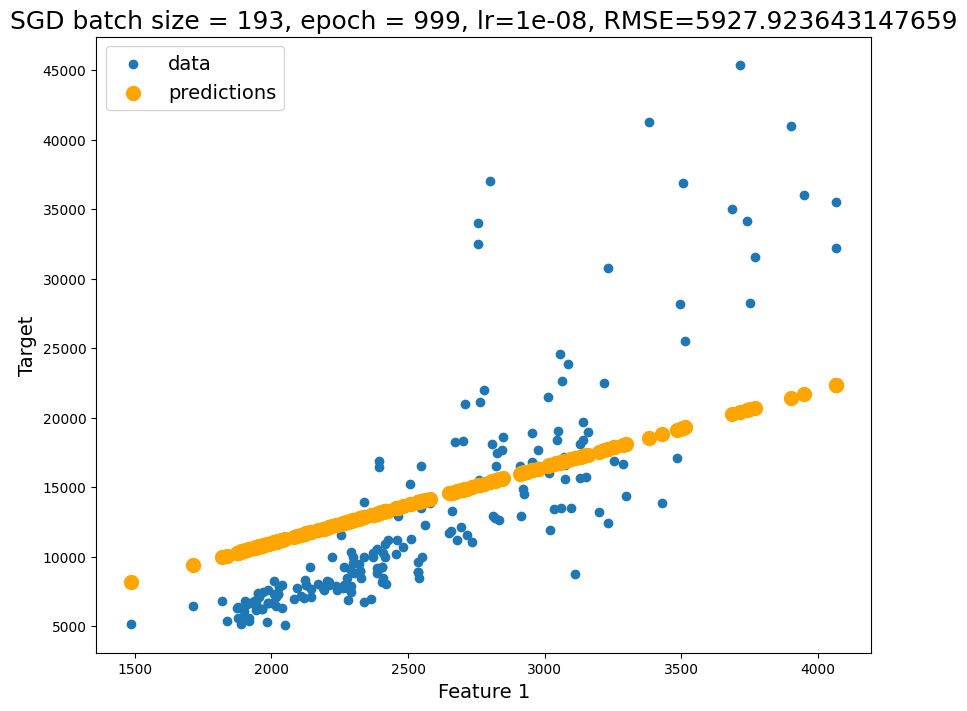

In [ ]:
results = []
for b in [1, 10, 50, len(Data)]:
  for m in [100, 1000]:
    for lr in [1e-3, 1e-6, 1e-8]:
      sgd = MyLinearRegression(lr=lr, batch_size=b, weight_calc='sgd')
      sgd.fit(Data[[13]],Data[25], max_iter=m)
      r = np.sqrt(np.mean((sgd.predict(Data[[13]])-Data[25].to_numpy())**2))
      results.append({'Batch Size': b, 'Max Epochs': m, 'Learning Rate': lr, 'RMSE Value': r})

In [ ]:
results_df = pd.DataFrame(results)
results_df

,Batch Size,Max Epochs,Learning Rate,RMSE Value
0,1,100,1.000000e-03,NaN
1,1,100,1.000000e-06,6.006118e+80
2,1,100,1.000000e-08,5.927937e+03
3,1,1000,1.000000e-03,NaN
4,1,1000,1.000000e-06,NaN
5,1,1000,1.000000e-08,5.927924e+03
6,10,100,1.000000e-03,NaN
7,10,100,1.000000e-06,6.006118e+80
8,10,100,1.000000e-08,5.927937e+03
9,10,1000,1.000000e-03,NaN


## Normalize the feature column and repeat the experiment.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_sc = scaler.fit_transform(Data[[13]])

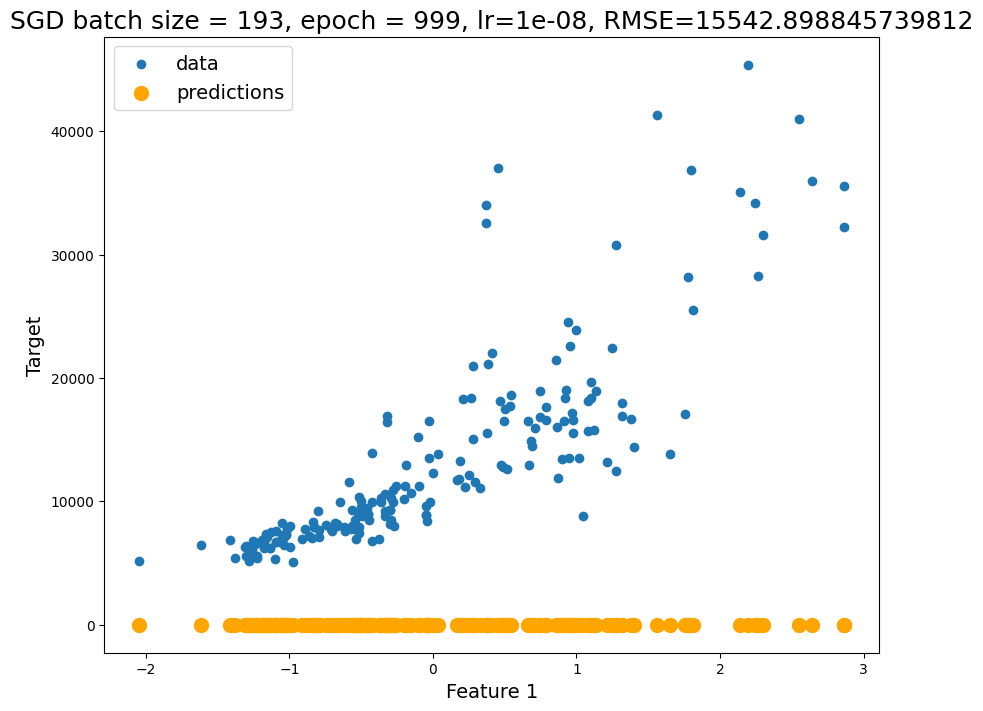

In [ ]:
results = []
for b in [1, 10, 50, len(Data)]:
  for m in [100, 1000]:
    for lr in [1e-3, 1e-6, 1e-8]:
      sgd = MyLinearRegression(lr=lr, batch_size=b, weight_calc='sgd')
      sgd.fit(data_sc,Data[25], max_iter=m)
      r = np.sqrt(np.mean((sgd.predict(Data[[13]])-Data[25].to_numpy())**2))
      results.append({'Batch Size': b, 'Max Epochs': m, 'Learning Rate': lr, 'RMSE Value': r})

In [ ]:
results_df = pd.DataFrame(results)
results_df

,Batch Size,Max Epochs,Learning Rate,RMSE Value
0,1,100,1.000000e-03,1.664774e+06
1,1,100,1.000000e-06,1.392910e+04
2,1,100,1.000000e-08,1.552674e+04
3,1,1000,1.000000e-03,1.113726e+07
4,1,1000,1.000000e-06,6.766481e+03
5,1,1000,1.000000e-08,1.538016e+04
6,10,100,1.000000e-03,1.664774e+06
7,10,100,1.000000e-06,1.392910e+04
8,10,100,1.000000e-08,1.552674e+04
9,10,1000,1.000000e-03,1.113726e+07


###Type the answer

Larger batch sizes generally require larger learning rates for faster convergence, while smaller batch sizes benefit from smaller learning rates to avoid overshooting. Feature scaling improves training by ensuring features contribute equally, leading to lower RMSE values. The results should show better performance (lower RMSE) with scaled features compared to unscaled features. The relationship between batch size and learning rate should follow the general trend of larger batches needing larger learning rates and vice versa. Feature scaling is important for improving model performance and convergence speed.




#3. (10pt) In this part you will use the built-in functions for Linear Regression. They are using SGD under the hood.

(1pt) Plot the histograms for numerical data and bar-plots for categorical features, add $x$ axis name (file Description.txt). You can get the names of the columns as follows:
```
# List of numerical columns (assuming they have numeric data types)
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

# List of nominal (categorical) columns (assuming they have object data types)
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

```
And then methods
```
Data[column].hist()
Data[column].value_counts().plot(kind='bar')
```

(1pt) Transform categorical data into numerical ([see SGD notebook from Fall](https://github.com/anton-selitskiy/RIT_ML/blob/main/2024_fall/Lectures/ML9.ipynb)).

(3pt) Choose the features for prediction ([see Model Selection notebook from Week 4](https://github.com/anton-selitskiy/RIT_ML/tree/main/2025_spring/Week04_SGD/ML7.ipynb))

(3pt) Choose the model by the grid-search (using validation set or cross-validation)

(2pt) Train the best model and report it's performance on the Test set. Justify your choice of the metric for evaluation.

In [4]:
# To have the names of the columns, we upload file Description.txt
descripsion = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2024_spring/Homeworks/Description.txt', delimiter=':', header=None)
Data.columns = descripsion[0].str.strip() #delete extra spaces in the column names
Data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


(1pt) Plot the histograms for numerical data and bar-plots for categorical features, add  x  axis name (file Description.txt). You can get the names of the columns as follows:

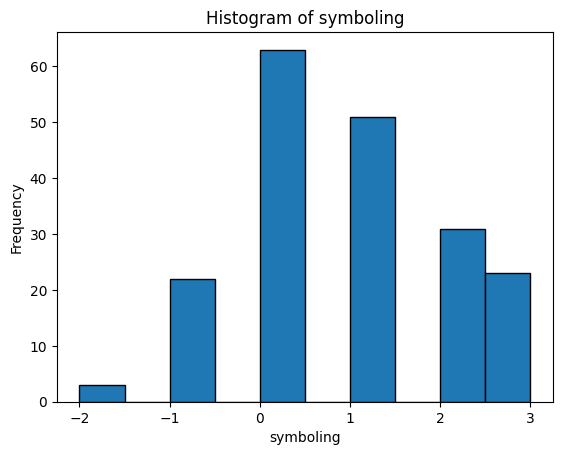

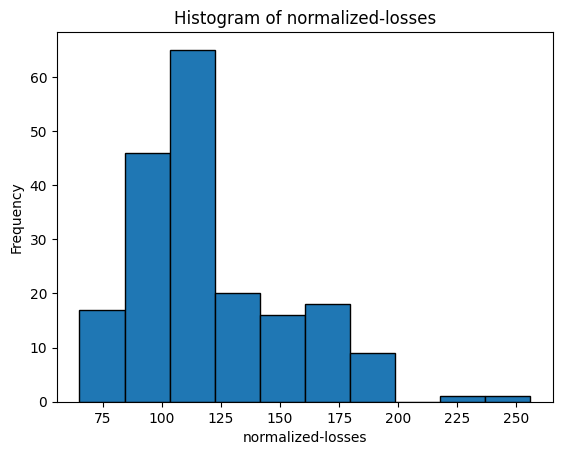

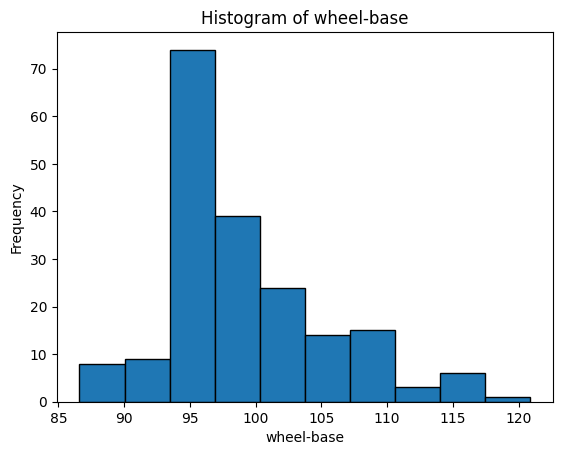

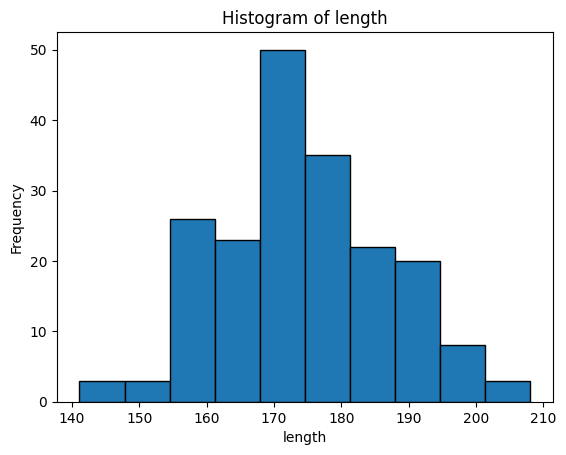

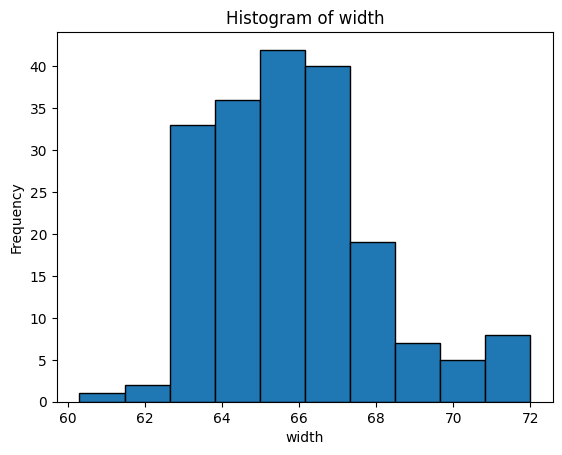

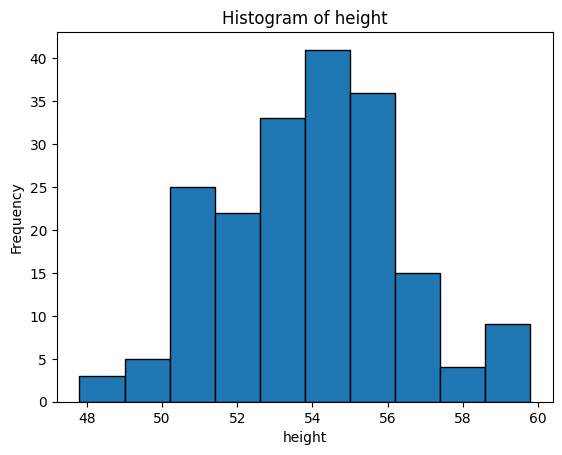

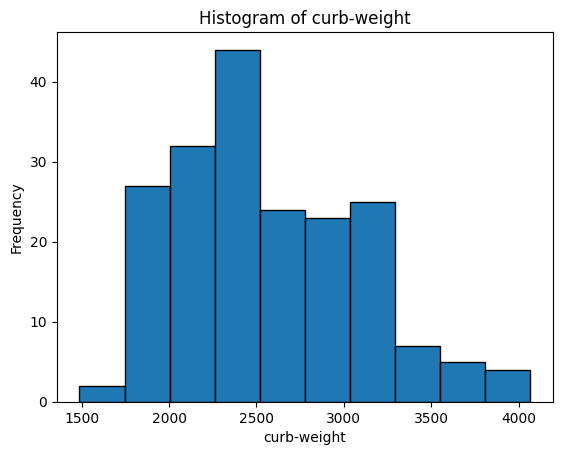

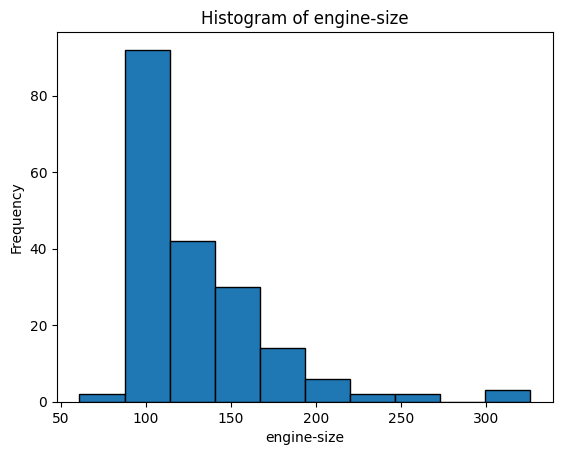

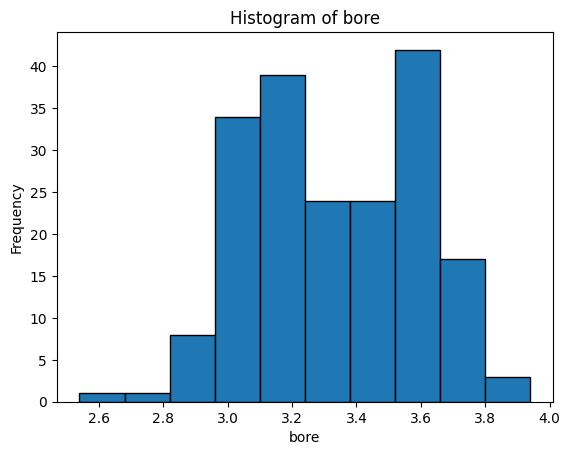

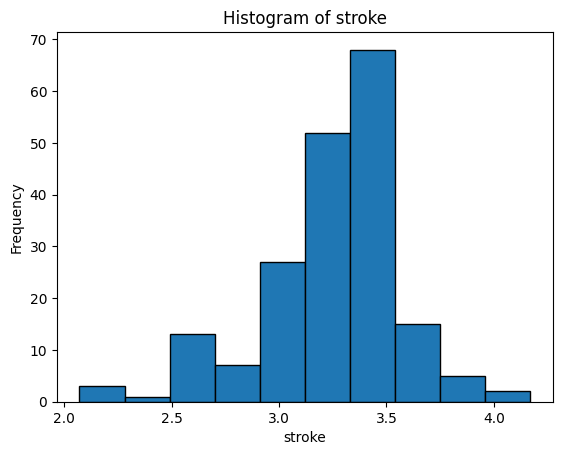

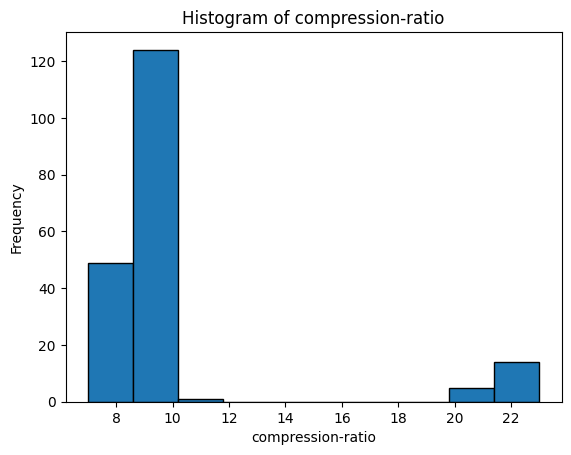

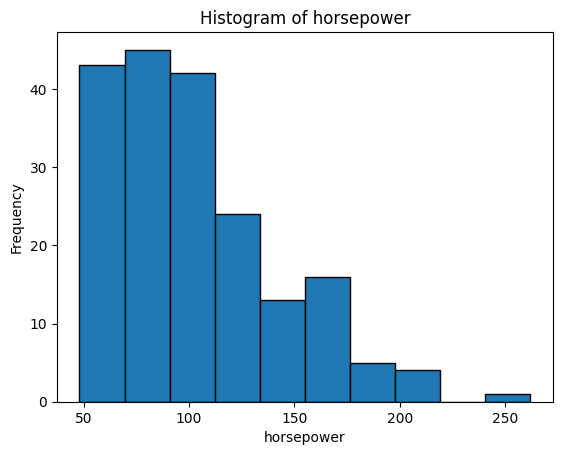

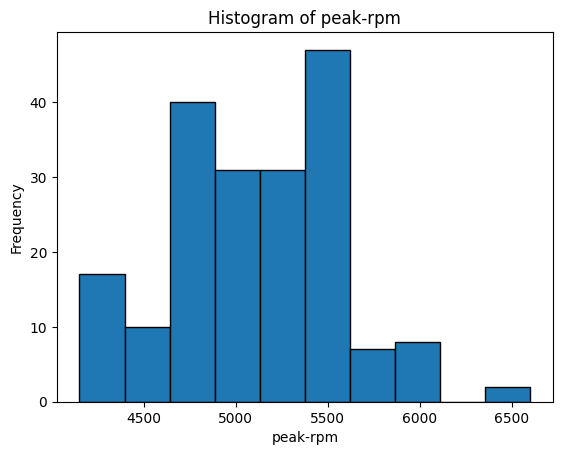

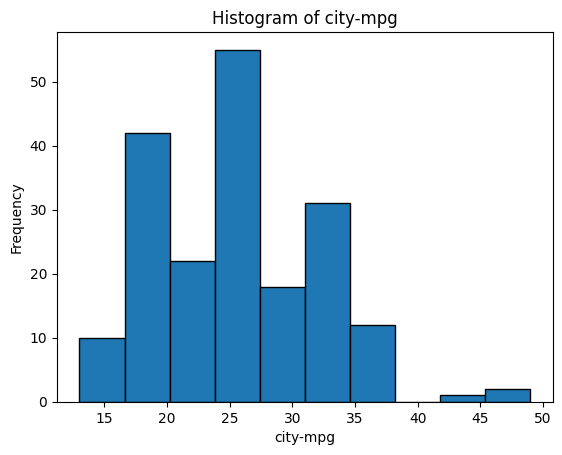

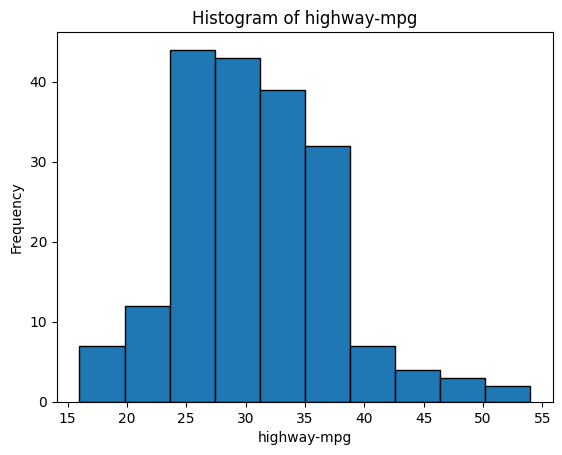

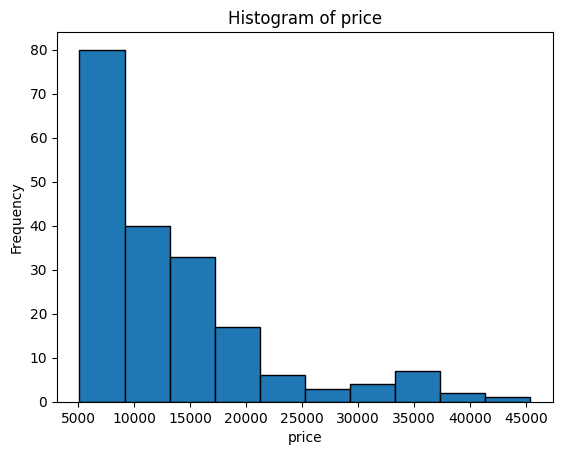

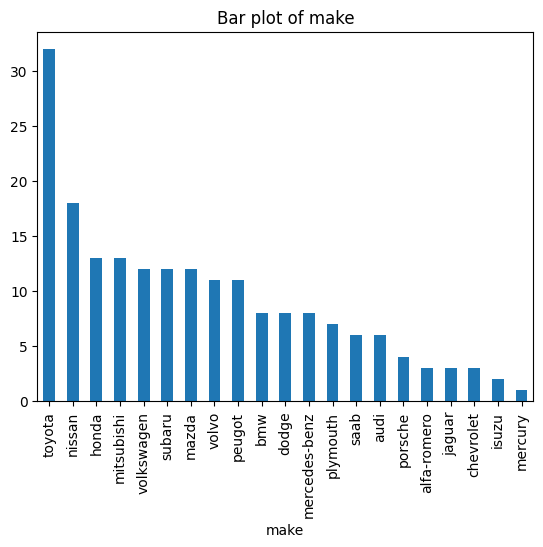

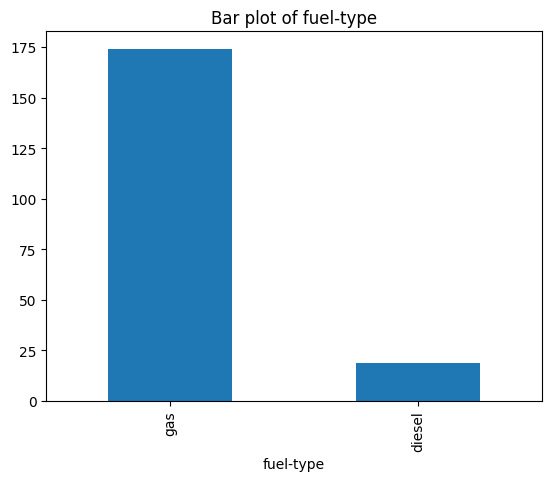

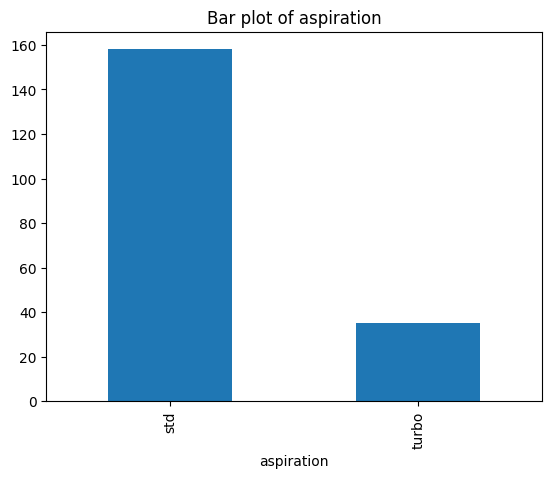

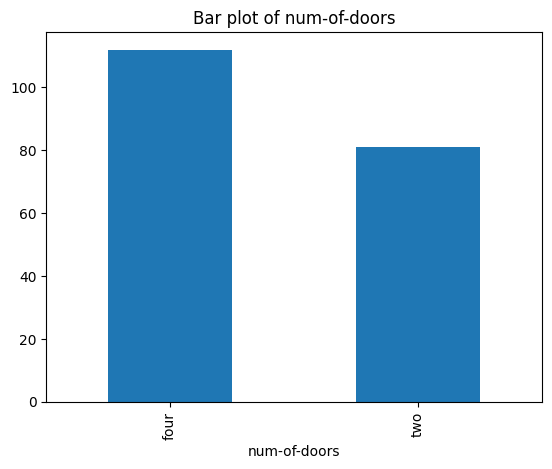

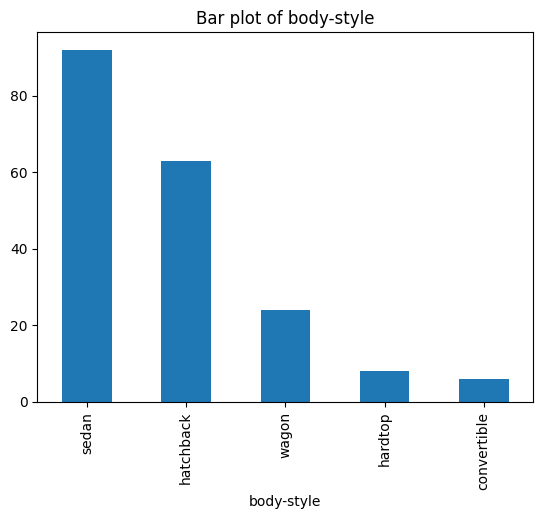

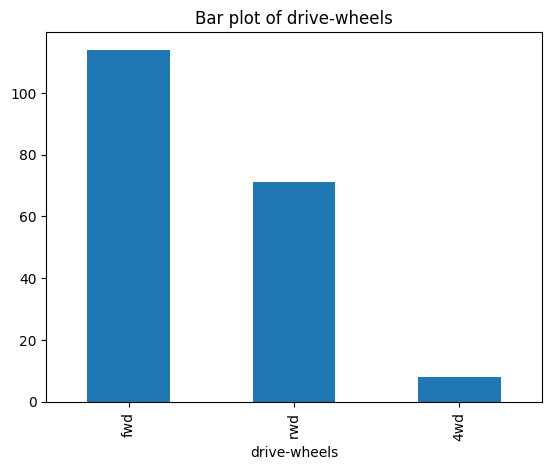

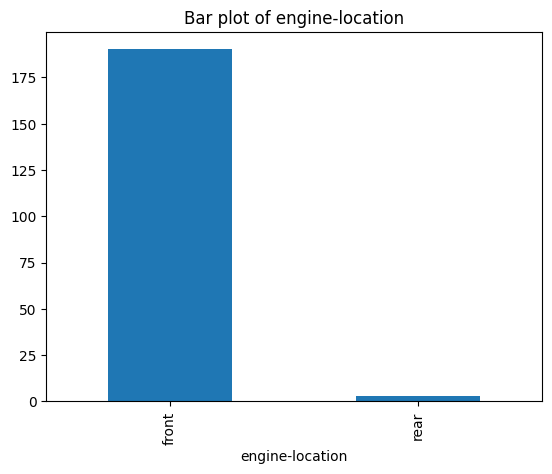

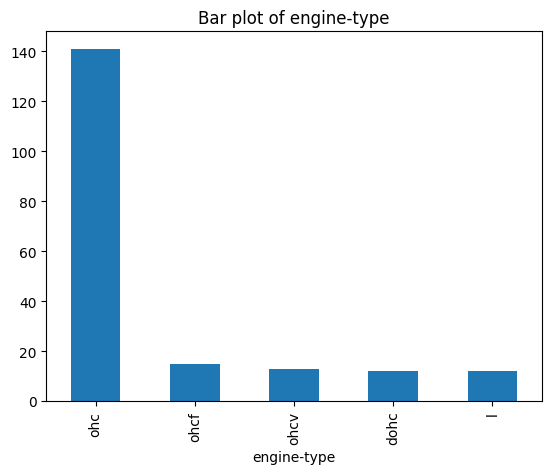

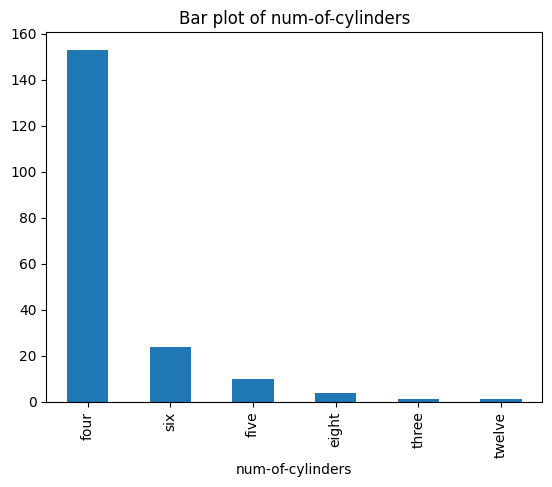

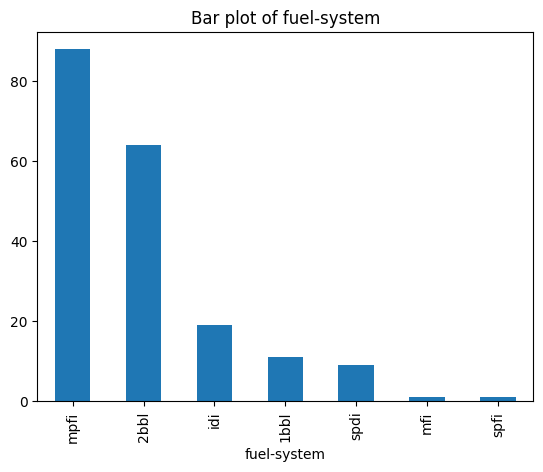

In [10]:
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

# Plotting histograms for numerical features
for col in numerical_columns:
    plt.figure()  # Create a new figure for each histogram
    Data[col].hist(edgecolor='black', grid=False)
    plt.xlabel(col)  # Add x-axis label
    plt.ylabel('Frequency')  # Add y-axis label
    plt.title(f'Histogram of {col}')
    plt.show()

# Plotting bar plots for categorical features
for col in nominal_columns:
    plt.figure()  # Create a new figure for each bar plot
    Data[col].value_counts().plot(kind='bar')
    plt.xlabel(col)  # Add x-axis label
    plt.title(f'Bar plot of {col}')
    plt.show()

(1pt) Transform categorical data into numerical (see SGD notebook from Fall).

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Select only categorical features for transformation
categorical_features = Data.select_dtypes(include=['object']).columns.tolist()

# Create and apply the ColumnTransformer
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='ignore'),
                                categorical_features)], remainder='passthrough')

# Fit and transform the data (all columns, including 'price')
transformed_data = transform.fit_transform(Data)

# Display the transformed data
pd.DataFrame(transformed_data, columns=transform.get_feature_names_out()).head()

,OneHot__make_audi,OneHot__make_bmw,OneHot__make_chevrolet,OneHot__make_dodge,OneHot__make_honda,OneHot__make_isuzu,OneHot__make_jaguar,OneHot__make_mazda,OneHot__make_mercedes-benz,OneHot__make_mercury,...,remainder__curb-weight,remainder__engine-size,remainder__bore,remainder__stroke,remainder__compression-ratio,remainder__horsepower,remainder__peak-rpm,remainder__city-mpg,remainder__highway-mpg,remainder__price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2823.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2337.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2824.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


(3pt) Choose the features for prediction (see Model Selection notebook from Week 4)

Using RFE:

In [58]:
from sklearn.feature_selection import RFE

Rec_select = []
for r in range(1, X_train_hot.shape[1]):
  estimator = Lasso()
  scaler = StandardScaler()
  selector = RFE(estimator, n_features_to_select=r)
  selector.fit(scaler.fit_transform(X_train_hot), y_train)

  X_train_hot_df = pd.DataFrame(X_train_hot, columns=transform.get_feature_names_out())

  Rec_select.append(cross_val_score(estimator,
                                   scaler.fit_transform(X_train_hot_df[selector.get_feature_names_out(X_train_hot_df.columns)]),
                                   y_train, cv=10).mean())

estimator = Lasso()
scaler = StandardScaler()
selector_Rec = RFE(estimator, n_features_to_select=9)
selector_Rec.fit(scaler.fit_transform(X_train_hot), y_train)

X_train_hot_df = pd.DataFrame(X_train_hot, columns=transform.get_feature_names_out())

selector_Rec.get_feature_names_out(X_train_hot_df.columns)

array(['remainder__engine-size', 'remainder__bore', 'remainder__stroke',
       'remainder__compression-ratio', 'remainder__horsepower',
       'remainder__peak-rpm', 'remainder__city-mpg',
       'remainder__highway-mpg', 'remainder__price'], dtype=object)

Using MI:

In [75]:
MI_select = []
for r in range(1, X_train_hot.shape[1]):
  pipe2 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
  MI_select.append(cross_val_score(pipe2, SelectKBest(mutual_info_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

selector_MI = SelectKBest(mutual_info_regression, k=9)
selector_MI.fit_transform(X_train_hot, y_train)

X_train_hot_df = pd.DataFrame(X_train_hot, columns=transform.get_feature_names_out())

selector_Rec.get_feature_names_out(X_train_hot_df.columns)

array(['remainder__engine-size', 'remainder__bore', 'remainder__stroke',
       'remainder__compression-ratio', 'remainder__horsepower',
       'remainder__peak-rpm', 'remainder__city-mpg',
       'remainder__highway-mpg', 'remainder__price'], dtype=object)

(3pt) Choose the model by the grid-search (using validation set or cross-validation)

In [62]:
pipe3 = Pipeline([('select', SelectKBest()),('sc', StandardScaler()), ('reg', ElasticNet())])

pipe3.get_params()

{'memory': None,
 'steps': [('select', SelectKBest()),
  ('sc', StandardScaler()),
  ('reg', ElasticNet())],
 'transform_input': None,
 'verbose': False,
 'select': SelectKBest(),
 'sc': StandardScaler(),
 'reg': ElasticNet(),
 'select__k': 10,
 'select__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'reg__alpha': 1.0,
 'reg__copy_X': True,
 'reg__fit_intercept': True,
 'reg__l1_ratio': 0.5,
 'reg__max_iter': 1000,
 'reg__positive': False,
 'reg__precompute': False,
 'reg__random_state': None,
 'reg__selection': 'cyclic',
 'reg__tol': 0.0001,
 'reg__warm_start': False}

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {'select__score_func': [mutual_info_regression, f_regression],
              'select__k': [8, 9],
              'reg__alpha': [0.1, 0.5],
              'reg__l1_ratio': [0, 0.5, 1]
              }

grid_search = GridSearchCV(pipe3, param_grid, cv=5)

grid_search.fit(X_train_hot, y_train)

selector = grid_search.best_estimator_.named_steps['select']

# Convert X_train_hot to DataFrame with appropriate column names
X_train_hot_df = pd.DataFrame(X_train_hot, columns=transform.get_feature_names_out())

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get original column names using the selected indices
selected_feature_names_original = X_train_hot_df.columns[selected_feature_indices].tolist()

# Print the original column names
print(selected_feature_names_original)

['remainder__wheel-base', 'remainder__length', 'remainder__width', 'remainder__curb-weight', 'remainder__engine-size', 'remainder__horsepower', 'remainder__city-mpg', 'remainder__highway-mpg', 'remainder__price']


(2pt) Train the best model and report it's performance on the Test set. Justify your choice of the metric for evaluation.

In [66]:
from sklearn.linear_model import SGDRegressor

In [78]:
best_model = SGDRegressor(alpha=0.001, penalty='elasticnet')
best_features = selector_MI.get_feature_names_out().tolist()

pipe = grid_search.best_estimator_

pipe.fit(X_train_hot, y_train)

y_pred = pipe.predict(X_test_hot)

# Calculate R^2 score on the test set
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

print(f"R^2 score on the test set: {r2}")

R^2 score on the test set: 0.9999999946829544


I chose the R^2 score as the evaluation metric for this problem because it provides a measure of how well the model explains the variance in the target variable (median house value). R^2 values range from 0 to 1, where a higher value indicates a better fit. In this context, a higher R^2 score suggests that the model is effectively capturing the relationships between the features and the target variable, leading to more accurate predictions. It's also a widely used and easily interpretable metric for regression tasks.